In [197]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn import  metrics, svm
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

In [2]:
discrete_features = ['Sex','Smoking history','ECOG score','Histologic type','Classification of Immunotherapy Drugs',
                    'Therapy line','BMI category','Hemoglobin levels','Albumin levels','CRP levels',
                    'LIPI','Stage at diagnosis','COPD','Bone metastasis','Brain  metastasis','Liver metastasis',
                    'Pleural effusion','Pericardial effusion']
continue_feautres = ['Age','Height','Weight','BMI','Hemoglobin','Albumin','NLR','LMR','PLR','ALI','SII']

## compared models for PFS

In [ ]:
# ROC
from sklearn.metrics import confusion_matrix
# LeaveOneOut
def flatten(nested):
    try:
        for sublist in nested:
            for element in flatten(sublist):
                yield element
    except TypeError:
        yield nested

        
df_cox = pd.read_table('results/cox/multi_var_cox_PFS.tsv')
features = ['Label_0'] + df_cox[df_cox.pvalue < 0.05].iloc[:,0].to_list()
print('Features: ', features[1:])

# one-hot
df = pd.read_table('results/merge/merge_data_PFS.tsv')
df = df.loc[:, features]
for fea in features:
    if fea in discrete_features:
        data1 = pd.get_dummies(df[fea])
        data1.columns = [fea + str(i) for i in data1.columns.to_list()]
        df = df.join(data1)
        df = df.drop([fea], axis=1)
    else:
        pass

# data
data = df.iloc[:, 1:]
y_data = df.iloc[:, 0]
predictlabel_list = []
reallabel_list = []
Y_score_list = []
loo = LeaveOneOut()

####################### Plot init ##################################
plt.figure()
lw = 3

####################### LogisticRegression ##################################
y_pred = []
for train_index, test_index in loo.split(data):
    X_train, y_train = data.iloc[train_index,:], y_data[train_index]
    X_test, y_test = data.iloc[test_index,:], y_data[test_index]

    # model
    classifier = LogisticRegression(n_jobs = -1, solver='saga')
    columns = X_train.columns.tolist()
    classifier.fit(X_train[columns], y_train)
    predictlabel_list.append(list(classifier.predict(X_test)))
    reallabel_list.append(list(y_test))
    Y_score_temp = classifier.decision_function(X_test)
    Y_score_list.append(Y_score_temp)
real = np.array(list(flatten(reallabel_list)))
# AUC
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
auc_ = auc(fpr, tpr)
print("LR AUC: ", auc_)
# plot
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Logistic Model (area = %0.3f)' % auc_)

########################### SVM #####################################
#Gridsearch CV
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
candidate_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
                     }  
model = svm.SVC(random_state=42)
gs = GridSearchCV(model, 
                  candidate_params, 
                  refit = True, 
                  cv = k_fold, 
                  verbose = 1, 
                  n_jobs = -1)
gs.fit(data.values, y_data.values)

# Train Model with best param
for train_index, test_index in loo.split(data):
    X_train, y_train = data.iloc[train_index,:], y_data[train_index]
    X_test, y_test = data.iloc[test_index,:], y_data[test_index]

    # model
    classifier = svm.SVC(kernel='poly', random_state=42)
    columns = X_train.columns.tolist()
    classifier.fit(X_train[columns], y_train)
    predictlabel_list.append(list(classifier.predict(X_test)))
    reallabel_list.append(list(y_test))

    Y_score_temp = classifier.decision_function(X_test) 
    Y_score_list.append(Y_score_temp)
real = np.array(list(flatten(reallabel_list)))
# AUC
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
auc_ = auc(fpr, tpr)
print("SVM AUC: ", auc_)
# plot
plt.plot(fpr, tpr, color='#5bd1d7',
         lw=lw, label='SVM Model (area = %0.3f)' % auc_)


########################### Random Foreset #####################################
# Gridsearch CV
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
candidate_params = {'max_features': list(range(2, 10,1)), 
                    'n_estimators': list(range(2, 10,1)), 
                    'max_depth': list(range(2, 10,1)),
                    'max_leaf_nodes': list(range(2, 10,1))
                     }  
model = RandomForestClassifier(random_state=seed)
gs = GridSearchCV(model, 
                  candidate_params, 
                  refit = True, 
                  cv = k_fold, 
                  verbose = 1, 
                  n_jobs = -1)
gs.fit(data.values, y_data.values)

# Train Model with best param
for train_index, test_index in loo.split(data):
    X_train, y_train = data.iloc[train_index,:], y_data[train_index]
    X_test, y_test = data.iloc[test_index,:], y_data[test_index]
    # model
    classifier = RandomForestClassifier(**gs.best_params_, random_state=42)
    columns = X_train.columns.tolist()
    classifier.fit(X_train[columns], y_train)
    predictlabel_list.append(list(classifier.predict(X_test)))
    reallabel_list.append(list(y_test))
    Y_score_temp = classifier.predict_proba(X_test)[:,1] 
    Y_score_list.append(Y_score_temp)
real = np.array(list(flatten(reallabel_list)))
# AUC
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
auc_ = auc(fpr, tpr)
# Sensitivity Specificty
tn, fp, fn, tp = confusion_matrix(reallabel_list, predictlabel_list).ravel()
sens = tp / (tp + fn)
spec= tn / (tn + fp) 
print("RF AUC: ", auc_, "Sensitivity: ", sens, "Specificty: ", spec)
plt.plot(fpr, tpr, color='#fe5f55',
         lw=lw, label='RF Model (area = %0.3f)' % auc_)


########################### Output Figure #####################################
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--', label="Reference Line")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# plt.title('ROC curve for PFS with LeaveOneOut')
plt.legend(loc="lower right")
plt.savefig('ROC_curve_PFS_compared_methods.pdf')

## conctruct LR model for PFS

Features:  ['Rad_score_pulmonary', 'PLR', 'Bone metastasis']
AUC:  0.8113804004214963
ACC:  0.7857142857142857


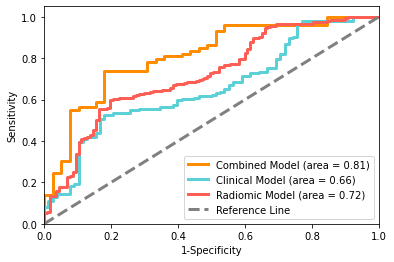

In [208]:
# 绘制多个ROC

# 留一法
def flatten(nested):
    try:
        for sublist in nested:
            for element in flatten(sublist):
                yield element
    except TypeError:
        yield nested

        
df_cox = pd.read_table('results/cox/multi_var_cox_PFS.tsv')
features = ['Label_0'] + df_cox[df_cox.pvalue < 0.05].iloc[:,0].to_list()
print('Features: ', features[1:])

# one-hot
df = pd.read_table('results/merge/merge_data_PFS.tsv')
df = df.loc[:, features]
for fea in features:
    if fea in discrete_features:
        data1 = pd.get_dummies(df[fea])
        data1.columns = [fea + str(i) for i in data1.columns.to_list()]
        df = df.join(data1)
        df = df.drop([fea], axis=1)
    else:
        pass

# data
data = df.iloc[:, 1:]
y_data = df.iloc[:, 0]
predictlabel_list = []
reallabel_list = []
Y_score_list = []

loo = LeaveOneOut()

count_right_label = 0
count = 0
for train_index, test_index in loo.split(data):
    X_train, y_train = data.iloc[train_index,:], y_data[train_index]
    X_test, y_test = data.iloc[test_index,:], y_data[test_index]

    # model
    classifier = LogisticRegression(n_jobs = -1)
    columns = X_train.columns.tolist()
    classifier.fit(X_train[columns], y_train)
    predictlabel_list.append(list(classifier.predict(X_test)))
    reallabel_list.append(list(y_test))

    Y_score_temp = classifier.decision_function(X_test)
    Y_score_list.append(Y_score_temp)

    if y_test in classifier.predict(X_test):
        count_right_label += 1
    count += 1
accurancy = count_right_label / df.shape[0]

real = np.array(list(flatten(reallabel_list)))
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
print("AUC: ", roc_auc)
print("ACC: ", accurancy)

##ROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
real = np.array(list(flatten(reallabel_list)))
roc_auc = dict()
Y_combined, Score_combined = real, np.array(Y_score_list)[:,0]  # for delong test
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 3

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Combined Model (area = %0.2f)' % roc_auc)


### Clinical model
count_right_label = 0
count = 0
for train_index, test_index in loo.split(data):
    X_train, y_train = data.iloc[train_index,:], y_data[train_index]
    X_test, y_test = data.iloc[test_index,:], y_data[test_index]
    X_train = X_train.loc[:,['PLR', 'Bone metastasis0','Bone metastasis1','Bone metastasis2']]
    X_test = X_test.loc[:,['PLR', 'Bone metastasis0','Bone metastasis1','Bone metastasis2']]
    # model
    classifier = LogisticRegression(n_jobs = -1)
    columns = X_train.columns.tolist()
    classifier.fit(X_train[columns], y_train)
    predictlabel_list.append(list(classifier.predict(X_test)))
    reallabel_list.append(list(y_test))

    Y_score_temp = classifier.decision_function(X_test)
    Y_score_list.append(Y_score_temp)

    if y_test in classifier.predict(X_test):
        count_right_label += 1
    count += 1
accurancy = count_right_label / df.shape[0]

real = np.array(list(flatten(reallabel_list)))
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
#ROC
real = np.array(list(flatten(reallabel_list)))
roc_auc = dict()
Y_clin, Score_clin = real, np.array(Y_score_list)[:,0]  # for delong test
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='#5bd1d7',
         lw=lw, label='Clinical Model (area = %0.2f)' % roc_auc)


### Rad model
count_right_label = 0
count = 0
for train_index, test_index in loo.split(data):
    X_train, y_train = data.iloc[train_index,:], y_data[train_index]
    X_test, y_test = data.iloc[test_index,:], y_data[test_index]
    X_train = X_train.loc[:,['Rad_score_pulmonary']]
    X_test = X_test.loc[:,['Rad_score_pulmonary']]
    # model
    classifier = LogisticRegression(n_jobs = -1)
    columns = X_train.columns.tolist()
    classifier.fit(X_train[columns], y_train)
    predictlabel_list.append(list(classifier.predict(X_test)))
    reallabel_list.append(list(y_test))

    Y_score_temp = classifier.decision_function(X_test)
    Y_score_list.append(Y_score_temp)

    if y_test in classifier.predict(X_test):
        count_right_label += 1
    count += 1
accurancy = count_right_label / df.shape[0]

real = np.array(list(flatten(reallabel_list)))
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
#ROC
real = np.array(list(flatten(reallabel_list)))
roc_auc = dict()
Y_rad, Score_rad = real, np.array(Y_score_list)[:,0]  # for delong test
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='#fe5f55',
         lw=lw, label='Radiomic Model (area = %0.2f)' % roc_auc)


plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--', label="Reference Line")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# plt.title('ROC curve for PFS with LeaveOneOut')
plt.legend(loc="lower right")

plt.savefig('ROC_curve_PFS.pdf')

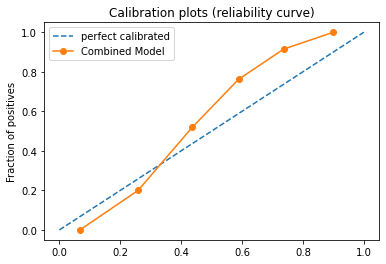

In [124]:
# Calibration curve

probs = classifier.decision_function(data)
prob_true, prob_pred = calibration_curve(y_data, probs, n_bins=6, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', label='perfect calibrated')
plt.plot(prob_pred,prob_true, 'o-', label='Combined Model')
plt.ylabel('Fraction of positives')
plt.title('Calibration plots (reliability curve)')
plt.legend()
plt.savefig('Calibration_PFS.pdf')

In [214]:
# Delong test

import rpy2.robjects as robj
r = robj.r
from rpy2.robjects.packages import importr

def roc_test_r(targets_1, scores_1, targets_2, scores_2, method='delong'):
    # method: “delong”, “bootstrap” or “venkatraman”
    importr('pROC')
    robj.globalenv['targets_1'] = targets_1 = robj.FloatVector(targets_1)
    robj.globalenv['scores_1'] = scores_1 = robj.FloatVector(scores_1)
    robj.globalenv['targets_2'] = targets_2 = robj.FloatVector(targets_2)
    robj.globalenv['scores_2'] = scores_2 = robj.FloatVector(scores_2)

    r('roc_1 <- roc(targets_1, scores_1)')
    r('roc_2 <- roc(targets_2, scores_2)')
    r('result = roc.test(roc_1, roc_2, method="%s")' % method)
    p_value = r('p_value = result$p.value')
    return np.array(p_value)[0]


cc = roc_test_r(Y_combined, Score_combined, Y_clin, Score_clin)
cr = roc_test_r(Y_combined, Score_combined, Y_rad, Score_rad)
clr = roc_test_r(Y_clin, Score_clin, Y_rad, Score_rad)

cc, cr, clr

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



(0.007752468830414603, 0.08430375352275321, 0.18268881105368343)

Group1 and Group2, log-rank test pvalue:  0.00010269725063661297


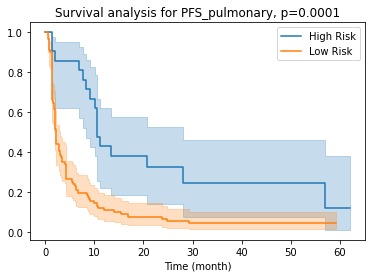

In [11]:
# survival

y_pred = classifier.predict(data)

df = pd.read_table('./results/merge/merge_data_PFS.tsv')
df['y_pred'] = y_pred

# log-rank test
results=logrank_test(df[df.y_pred == 0].PFS.to_list(), 
                     df[df.y_pred == 1].PFS.to_list(),
                     event_observed_A=df[df.y_pred == 0].PFS_status.to_list(), 
                     event_observed_B=df[df.y_pred == 1].PFS_status.to_list())
pvalue = results.p_value
print('Group1 and Group2, log-rank test pvalue: ', pvalue)

# plot
kmf = KaplanMeierFitter()
ax = plt.subplot(111)
kmf.fit(df[df.y_pred == 0].PFS.to_list(), event_observed=df[df.y_pred == 0].PFS_status.to_list(), label='High Risk')
kmf.plot(ax=ax)
kmf.fit(df[df.y_pred == 1].PFS.to_list(), event_observed=df[df.y_pred == 1].PFS_status.to_list(), label='Low Risk')
kmf.plot(ax=ax)
plt.xlabel('Time (month)')
plt.title('Survival analysis for PFS_pulmonary, p={}'.format( round(pvalue, 5)))
plt.savefig("PFS_pulmonary.survival.pdf")

## compared methods for OS

In [ ]:
# 绘制多个ROC

# 留一法
def flatten(nested):
    try:
        for sublist in nested:
            for element in flatten(sublist):
                yield element
    except TypeError:
        yield nested

        
df_cox = pd.read_table('results/cox/multi_var_cox_OS.tsv')
features = ['Label_1'] + df_cox[df_cox.pvalue < 0.05].iloc[:,0].to_list()
print('Features: ', features[1:])

# one-hot
df = pd.read_table('results/merge/merge_data_OS.tsv')
df = df.loc[:, features]
for fea in features:
    if fea in discrete_features:
        data1 = pd.get_dummies(df[fea])
        data1.columns = [fea + str(i) for i in data1.columns.to_list()]
        df = df.join(data1)
        df = df.drop([fea], axis=1)
    else:
        pass

# data
data = df.iloc[:, 1:]
y_data = df.iloc[:, 0]
predictlabel_list = []
reallabel_list = []
Y_score_list = []
loo = LeaveOneOut()

####################### Plot init ##################################
plt.figure()
lw = 3

####################### LogisticRegression ##################################
y_pred = []
for train_index, test_index in loo.split(data):
    X_train, y_train = data.iloc[train_index,:], y_data[train_index]
    X_test, y_test = data.iloc[test_index,:], y_data[test_index]

    # model
    classifier = LogisticRegression(n_jobs = -1, solver='saga')
    columns = X_train.columns.tolist()
    classifier.fit(X_train[columns], y_train)
    predictlabel_list.append(list(classifier.predict(X_test)))
    reallabel_list.append(list(y_test))
    Y_score_temp = classifier.decision_function(X_test)
    Y_score_list.append(Y_score_temp)
real = np.array(list(flatten(reallabel_list)))
# AUC
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
auc_ = auc(fpr, tpr)
print("LR AUC: ", auc_)
# plot
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Logistic Model (area = %0.3f)' % auc_)

########################### SVM #####################################
#Gridsearch CV
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
candidate_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
                     }  
model = svm.SVC(random_state=42)
gs = GridSearchCV(model, 
                  candidate_params, 
                  refit = True, 
                  cv = k_fold, 
                  verbose = 1, 
                  n_jobs = -1)
gs.fit(data.values, y_data.values)

# Train Model with best param
for train_index, test_index in loo.split(data):
    X_train, y_train = data.iloc[train_index,:], y_data[train_index]
    X_test, y_test = data.iloc[test_index,:], y_data[test_index]

    # model
    classifier = svm.SVC(kernel='poly', random_state=42)
    columns = X_train.columns.tolist()
    classifier.fit(X_train[columns], y_train)
    predictlabel_list.append(list(classifier.predict(X_test)))
    reallabel_list.append(list(y_test))

    Y_score_temp = classifier.decision_function(X_test)       # 得到的结果为该类到超平面的距离
    Y_score_list.append(Y_score_temp)
real = np.array(list(flatten(reallabel_list)))
# AUC
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
auc_ = auc(fpr, tpr)
print("SVM AUC: ", auc_)
# plot
plt.plot(fpr, tpr, color='#5bd1d7',
         lw=lw, label='SVM Model (area = %0.3f)' % auc_)


########################### Random Foreset #####################################
# Gridsearch CV
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
candidate_params = {'max_features': list(range(2, 10,1)), 
                    'n_estimators': list(range(2, 10,1)), 
                    'max_depth': list(range(2, 10,1)),
                    'max_leaf_nodes': list(range(2, 10,1))
                     }  
model = RandomForestClassifier(random_state=seed)
gs = GridSearchCV(model, 
                  candidate_params, 
                  refit = True, 
                  cv = k_fold, 
                  verbose = 1, 
                  n_jobs = -1)
gs.fit(data.values, y_data.values)

# Train Model with best param
for train_index, test_index in loo.split(data):
    X_train, y_train = data.iloc[train_index,:], y_data[train_index]
    X_test, y_test = data.iloc[test_index,:], y_data[test_index]
    # model
    classifier = RandomForestClassifier(**gs.best_params_, random_state=42)
    columns = X_train.columns.tolist()
    classifier.fit(X_train[columns], y_train)
    predictlabel_list.append(list(classifier.predict(X_test)))
    reallabel_list.append(list(y_test))
    Y_score_temp = classifier.predict_proba(X_test)[:,1]      # 得到的结果为该类到超平面的距离
    Y_score_list.append(Y_score_temp)
real = np.array(list(flatten(reallabel_list)))
# AUC
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
auc_ = auc(fpr, tpr)
# Sensitivity Specificty
tn, fp, fn, tp = confusion_matrix(reallabel_list, predictlabel_list).ravel()
sens = tp / (tp + fn)
spec= tn / (tn + fp) 
print("RF AUC: ", auc_, "Sensitivity: ", sens, "Specificty: ", spec)
plt.plot(fpr, tpr, color='#fe5f55',
         lw=lw, label='RF Model (area = %0.3f)' % auc_)


########################### Output Figure #####################################
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--', label="Reference Line")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# plt.title('ROC curve for PFS with LeaveOneOut')
plt.legend(loc="lower right")
plt.savefig('ROC_curve_OS_compared_methods.pdf')

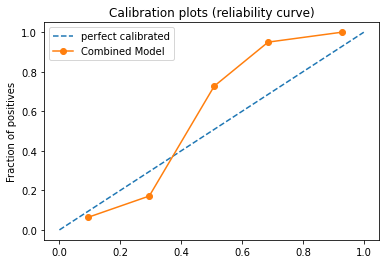

In [129]:
probs = classifier.decision_function(data)
prob_true, prob_pred = calibration_curve(y_data, probs, n_bins=5, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', label='perfect calibrated')
plt.plot(prob_pred,prob_true, 'o-', label='Combined Model')
plt.ylabel('Fraction of positives')
plt.title('Calibration plots (reliability curve)')
plt.legend()
plt.savefig('Calibration_OS.pdf')

## Construct models with LR for OS

Features:  ['Rad_score_pulmonary', 'Liver metastasis']
AUC:  0.9034369885433715
ACC:  0.8660714285714286


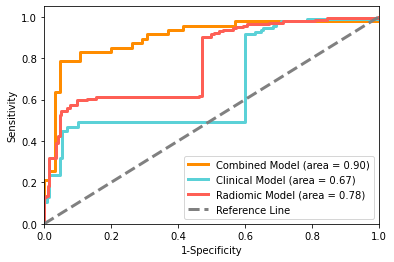

In [91]:
# 绘制多个ROC

# 留一法
def flatten(nested):
    try:
        for sublist in nested:
            for element in flatten(sublist):
                yield element
    except TypeError:
        yield nested

        
df_cox = pd.read_table('results/cox/multi_var_cox_OS.tsv')
features = ['Label_1'] + df_cox[df_cox.pvalue < 0.05].iloc[:,0].to_list()
print('Features: ', features[1:])

# one-hot
df = pd.read_table('results/merge/merge_data_OS.tsv')
df = df.loc[:, features]
for fea in features:
    if fea in discrete_features:
        data1 = pd.get_dummies(df[fea])
        data1.columns = [fea + str(i) for i in data1.columns.to_list()]
        df = df.join(data1)
        df = df.drop([fea], axis=1)
    else:
        pass

# data
data = df.iloc[:, 1:]
y_data = df.iloc[:, 0]

predictlabel_list = []
reallabel_list = []
Y_score_list = []

loo = LeaveOneOut()
count_right_label = 0
count = 0
for train_index, test_index in loo.split(data):
    X_train, y_train = data.iloc[train_index,:], y_data[train_index]
    X_test, y_test = data.iloc[test_index,:], y_data[test_index]

    # model
    classifier = LogisticRegression(n_jobs = -1)
    columns = X_train.columns.tolist()
    classifier.fit(X_train[columns], y_train)
    predictlabel_list.append(list(classifier.predict(X_test)))
    reallabel_list.append(list(y_test))

    Y_score_temp = classifier.decision_function(X_test)       # 得到的结果为该类到超平面的距离
    Y_score_list.append(Y_score_temp)

    if y_test in classifier.predict(X_test):
        count_right_label += 1
    count += 1
accurancy = count_right_label / df.shape[0]

real = np.array(list(flatten(reallabel_list)))
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
print("AUC: ", roc_auc)
print("ACC: ", accurancy)

##绘制ROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
real = np.array(list(flatten(reallabel_list)))
roc_auc = dict()
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 3

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Combined Model (area = %0.2f)' % roc_auc)


### Clinical
count_right_label = 0
count = 0
for train_index, test_index in loo.split(data):
    X_train, y_train = data.iloc[train_index,:], y_data[train_index]
    X_test, y_test = data.iloc[test_index,:], y_data[test_index]
    X_train = X_train.loc[:,['Liver metastasis0','Liver metastasis1','Liver metastasis2']]
    X_test = X_test.loc[:,['Liver metastasis0','Liver metastasis1','Liver metastasis2']]
    # model
    classifier = LogisticRegression(n_jobs = -1)
    columns = X_train.columns.tolist()
    classifier.fit(X_train[columns], y_train)
    predictlabel_list.append(list(classifier.predict(X_test)))
    reallabel_list.append(list(y_test))

    Y_score_temp = classifier.decision_function(X_test)       # 得到的结果为该类到超平面的距离
    Y_score_list.append(Y_score_temp)

    if y_test in classifier.predict(X_test):
        count_right_label += 1
    count += 1
accurancy = count_right_label / df.shape[0]

real = np.array(list(flatten(reallabel_list)))
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
#ROC
real = np.array(list(flatten(reallabel_list)))
roc_auc = dict()
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='#5bd1d7',
         lw=lw, label='Clinical Model (area = %0.2f)' % roc_auc)


### Radiomic
count_right_label = 0
count = 0
for train_index, test_index in loo.split(data):
    X_train, y_train = data.iloc[train_index,:], y_data[train_index]
    X_test, y_test = data.iloc[test_index,:], y_data[test_index]
    X_train = X_train.loc[:,['Rad_score_pulmonary']]
    X_test = X_test.loc[:,['Rad_score_pulmonary']]
    # model
    classifier = LogisticRegression(n_jobs = -1)
    columns = X_train.columns.tolist()
    classifier.fit(X_train[columns], y_train)
    predictlabel_list.append(list(classifier.predict(X_test)))
    reallabel_list.append(list(y_test))

    Y_score_temp = classifier.decision_function(X_test)       # 得到的结果为该类到超平面的距离
    Y_score_list.append(Y_score_temp)

    if y_test in classifier.predict(X_test):
        count_right_label += 1
    count += 1
accurancy = count_right_label / df.shape[0]

real = np.array(list(flatten(reallabel_list)))
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
#ROC
real = np.array(list(flatten(reallabel_list)))
roc_auc = dict()
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='#fe5f55',
         lw=lw, label='Radiomic Model (area = %0.2f)' % roc_auc)


plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--', label="Reference Line")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# plt.title('ROC curve for PFS with LeaveOneOut')
plt.legend(loc="lower right")

plt.savefig('ROC_curve_OS.pdf')

## Construct models with SVM for OS

Features:  ['Rad_score_pulmonary', 'Liver metastasis']
Fitting 5 folds for each of 4 candidates, totalling 20 fits
AUC:  0.9227495908346972


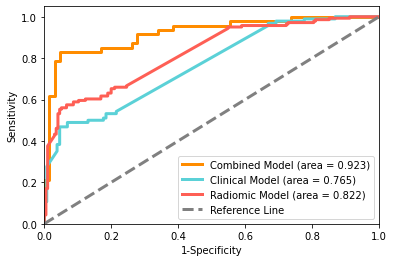

In [215]:
# 绘制多个ROC

# 留一法
def flatten(nested):
    try:
        for sublist in nested:
            for element in flatten(sublist):
                yield element
    except TypeError:
        yield nested

        
df_cox = pd.read_table('results/cox/multi_var_cox_OS.tsv')
features = ['Label_1'] + df_cox[df_cox.pvalue < 0.05].iloc[:,0].to_list()
print('Features: ', features[1:])

# one-hot
df = pd.read_table('results/merge/merge_data_OS.tsv')
df = df.loc[:, features]
for fea in features:
    if fea in discrete_features:
        data1 = pd.get_dummies(df[fea])
        data1.columns = [fea + str(i) for i in data1.columns.to_list()]
        df = df.join(data1)
        df = df.drop([fea], axis=1)
    else:
        pass

# data
data = df.iloc[:, 1:]
y_data = df.iloc[:, 0]
predictlabel_list = []
reallabel_list = []
Y_score_list = []
loo = LeaveOneOut()

########################### Gridsearch CV (SVM) #####################################
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
candidate_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
                     }  
model = svm.SVC(random_state=42)
gs = GridSearchCV(model, 
                  candidate_params, 
                  refit = True, 
                  cv = k_fold, 
                  verbose = 1, 
                  n_jobs = -1)
gs.fit(data.values, y_data.values)

########################### Combined Model (SVM) #####################################
for train_index, test_index in loo.split(data):
    X_train, y_train = data.iloc[train_index,:], y_data[train_index]
    X_test, y_test = data.iloc[test_index,:], y_data[test_index]
    # model
    classifier = svm.SVC(**gs.best_params_,random_state=42)
    columns = X_train.columns.tolist()
    classifier.fit(X_train[columns], y_train)
    predictlabel_list.append(list(classifier.predict(X_test)))
    reallabel_list.append(list(y_test))
    Y_score_temp = classifier.decision_function(X_test) 
    Y_score_list.append(Y_score_temp)
real = np.array(list(flatten(reallabel_list)))
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
print("AUC: ", roc_auc)

##绘制ROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
real = np.array(list(flatten(reallabel_list)))
roc_auc = dict()
Y_combined, Score_combined = real, np.array(Y_score_list)[:,0]  # for delong test
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 3
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Combined Model (area = %0.3f)' % roc_auc)

########################### Clinical Model (SVM) #####################################
for train_index, test_index in loo.split(data):
    X_train, y_train = data.iloc[train_index,:], y_data[train_index]
    X_test, y_test = data.iloc[test_index,:], y_data[test_index]
    X_train = X_train.loc[:,['Liver metastasis0','Liver metastasis1','Liver metastasis2']]
    X_test = X_test.loc[:,['Liver metastasis0','Liver metastasis1','Liver metastasis2']]
    # model
    classifier = svm.SVC(**gs.best_params_,random_state=42)
    columns = X_train.columns.tolist()
    classifier.fit(X_train[columns], y_train)
    predictlabel_list.append(list(classifier.predict(X_test)))
    reallabel_list.append(list(y_test))
    Y_score_temp = classifier.decision_function(X_test)       # 得到的结果为该类到超平面的距离
    Y_score_list.append(Y_score_temp)
real = np.array(list(flatten(reallabel_list)))
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
#ROC
real = np.array(list(flatten(reallabel_list)))
roc_auc = dict()
Y_clin, Score_clin = real, np.array(Y_score_list)[:,0]  # for delong test
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='#5bd1d7',
         lw=lw, label='Clinical Model (area = %0.3f)' % roc_auc)

########################### Radiomic (SVM) #####################################
for train_index, test_index in loo.split(data):
    X_train, y_train = data.iloc[train_index,:], y_data[train_index]
    X_test, y_test = data.iloc[test_index,:], y_data[test_index]
    X_train = X_train.loc[:,['Rad_score_pulmonary']]
    X_test = X_test.loc[:,['Rad_score_pulmonary']]
    # model
    classifier = svm.SVC(**gs.best_params_,random_state=42)
    columns = X_train.columns.tolist()
    classifier.fit(X_train[columns], y_train)
    predictlabel_list.append(list(classifier.predict(X_test)))
    reallabel_list.append(list(y_test))
    Y_score_temp = classifier.decision_function(X_test)       # 得到的结果为该类到超平面的距离
    Y_score_list.append(Y_score_temp)

real = np.array(list(flatten(reallabel_list)))
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
#ROC
real = np.array(list(flatten(reallabel_list)))
roc_auc = dict()
Y_rad, Score_rad = real, np.array(Y_score_list)[:,0]  # for delong test
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='#fe5f55',
         lw=lw, label='Radiomic Model (area = %0.3f)' % roc_auc)


plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--', label="Reference Line")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# plt.title('ROC curve for PFS with LeaveOneOut')
plt.legend(loc="lower right")

plt.savefig('ROC_curve_OS_SVM.pdf')

In [216]:
# Delong test

import numpy as np
import rpy2.robjects as robj
r = robj.r
from rpy2.robjects.packages import importr

def roc_test_r(targets_1, scores_1, targets_2, scores_2, method='delong'):
    # method: “delong”, “bootstrap” or “venkatraman”
    importr('pROC')
    robj.globalenv['targets_1'] = targets_1 = robj.FloatVector(targets_1)
    robj.globalenv['scores_1'] = scores_1 = robj.FloatVector(scores_1)
    robj.globalenv['targets_2'] = targets_2 = robj.FloatVector(targets_2)
    robj.globalenv['scores_2'] = scores_2 = robj.FloatVector(scores_2)

    r('roc_1 <- roc(targets_1, scores_1)')
    r('roc_2 <- roc(targets_2, scores_2)')
    r('result = roc.test(roc_1, roc_2, method="%s")' % method)
    p_value = r('p_value = result$p.value')
    return np.array(p_value)[0]


cc = roc_test_r(Y_combined, Score_combined, Y_clin, Score_clin)
cr = roc_test_r(Y_combined, Score_combined, Y_rad, Score_rad)
clr = roc_test_r(Y_clin, Score_clin, Y_rad, Score_rad)

cc, cr, clr

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



(9.791993991753529e-05, 0.004229503380495393, 0.1260597838892275)

Features:  ['Rad_score_pulmonary', 'Liver metastasis']
Fitting 5 folds for each of 4 candidates, totalling 20 fits
AUC:  0.9227495908346972


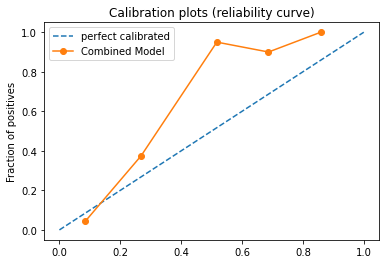

In [205]:
# Calibration curve

# 
def flatten(nested):
    try:
        for sublist in nested:
            for element in flatten(sublist):
                yield element
    except TypeError:
        yield nested

        
df_cox = pd.read_table('results/cox/multi_var_cox_OS.tsv')
features = ['Label_1'] + df_cox[df_cox.pvalue < 0.05].iloc[:,0].to_list()
print('Features: ', features[1:])

# one-hot
df = pd.read_table('results/merge/merge_data_OS.tsv')
df = df.loc[:, features]
for fea in features:
    if fea in discrete_features:
        data1 = pd.get_dummies(df[fea])
        data1.columns = [fea + str(i) for i in data1.columns.to_list()]
        df = df.join(data1)
        df = df.drop([fea], axis=1)
    else:
        pass

# data
data = df.iloc[:, 1:]
y_data = df.iloc[:, 0]
predictlabel_list = []
reallabel_list = []
Y_score_list = []
loo = LeaveOneOut()

########################### Gridsearch CV (SVM) #####################################
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
candidate_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
                     }  
model = svm.SVC(random_state=42)
gs = GridSearchCV(model, 
                  candidate_params, 
                  refit = True, 
                  cv = k_fold, 
                  verbose = 1, 
                  n_jobs = -1)
gs.fit(data.values, y_data.values)

########################### Combined Model (SVM) #####################################
for train_index, test_index in loo.split(data):
    X_train, y_train = data.iloc[train_index,:], y_data[train_index]
    X_test, y_test = data.iloc[test_index,:], y_data[test_index]
    # model
    classifier = svm.SVC(**gs.best_params_,random_state=42)
    columns = X_train.columns.tolist()
    classifier.fit(X_train[columns], y_train)
    predictlabel_list.append(list(classifier.predict(X_test)))
    reallabel_list.append(list(y_test))
    Y_score_temp = classifier.decision_function(X_test) 
    Y_score_list.append(Y_score_temp)
real = np.array(list(flatten(reallabel_list)))
fpr, tpr, threshold = roc_curve(real, np.array(Y_score_list))
roc_auc = auc(fpr, tpr)
print("AUC: ", roc_auc)


probs = classifier.decision_function(data)
prob_true, prob_pred = calibration_curve(y_data, probs, n_bins=5, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--', label='perfect calibrated')
plt.plot(prob_pred,prob_true, 'o-', label='Combined Model')
plt.ylabel('Fraction of positives')
plt.title('Calibration plots (reliability curve)')
plt.legend()
plt.savefig('Calibration_OS.pdf')

Group1 and Group2, log-rank test pvalue:  2.735697626186957e-06


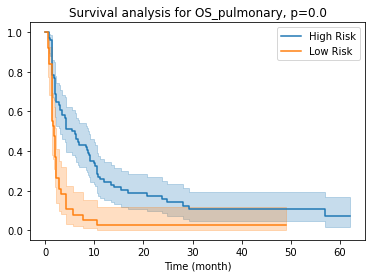

In [14]:
## survival

y_pred = classifier.predict(data)

df = pd.read_table('./results/merge/merge_data_OS.tsv')
df['y_pred'] = y_pred

# log-rank test
results=logrank_test(df[df.y_pred == 0].PFS.to_list(), 
                     df[df.y_pred == 1].PFS.to_list(),
                     event_observed_A=df[df.y_pred == 0].PFS_status.to_list(), 
                     event_observed_B=df[df.y_pred == 1].PFS_status.to_list())
pvalue = results.p_value
print('Group1 and Group2, log-rank test pvalue: ', pvalue)

# plot
kmf = KaplanMeierFitter()
ax = plt.subplot(111)
kmf.fit(df[df.y_pred == 0].PFS.to_list(), event_observed=df[df.y_pred == 0].PFS_status.to_list(), label='High Risk')
kmf.plot(ax=ax)
kmf.fit(df[df.y_pred == 1].PFS.to_list(), event_observed=df[df.y_pred == 1].PFS_status.to_list(), label='Low Risk')
kmf.plot(ax=ax)
plt.xlabel('Time (month)')
plt.title('Survival analysis for OS_pulmonary, p={}'.format( round(pvalue, 5)))
plt.savefig("OS.survival.pdf")